<h1 style="font-size:3rem;color:#3F778C; text-align:center;">Reto clustering</h1>


<h3 style="color:#6587A1; text-align:center;">Daniela Cortés Méndez<br>Sergio Andrés González Roa<br>Kareen Alejandra Latorre Martínez</h3>

# Imports

In [1]:
import numpy as np, numpy as np_test
import pandas as pd,pandas as pd_test
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
from mpl_toolkits.mplot3d import Axes3D  
from tqdm import tqdm
import datetime

# Importación de los datos

In [2]:
clients = pd.read_csv("./datos_de_clientes.csv", delimiter="\t")
clients.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Pre-procesamiento de los datos


In [3]:
current_year = datetime.datetime.now().year
clients['Age'] = current_year - clients['Year_Birth']

una linea

In [4]:
clients_education_encoded = pd.get_dummies(clients["Education"], prefix="Education", dtype=int)
clients = pd.concat([clients, clients_education_encoded], axis=1)

In [5]:
print(clients['Marital_Status'].value_counts())

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


In [6]:
marital_mode = str(clients['Marital_Status'].mode()[0])
print(f"mode: {marital_mode}")
clients['Marital_Status'] = clients['Marital_Status'].replace({'Alone': 'Single', 'Absurd': marital_mode, 'YOLO': marital_mode})
print(clients['Marital_Status'].value_counts())

mode: Married
Marital_Status
Married     868
Together    580
Single      483
Divorced    232
Widow        77
Name: count, dtype: int64


In [7]:
clients_marital_encoded = pd.get_dummies(clients["Marital_Status"], prefix="Marital_Status", dtype=int)
clients = pd.concat([clients, clients_marital_encoded], axis=1)

In [8]:
fill = KNNImputer(n_neighbors=1).fit_transform(clients[['Income']])
clients['Income'] = pd.DataFrame(fill, columns=['Income'])

In [9]:
clients['Days_Customer'] = (pd.to_datetime(datetime.datetime.now().strftime('%d-%m-%Y'), dayfirst=True) - pd.to_datetime(clients['Dt_Customer'], format='%d-%m-%Y')).dt.days

In [10]:
clients['Total_AcceptedCmp'] = clients['AcceptedCmp1'] + clients['AcceptedCmp2'] + clients['AcceptedCmp3'] + clients['AcceptedCmp4'] + clients['AcceptedCmp5'] + clients['Response']

In [11]:
clients['Total_SpentProducts'] = clients['MntWines'] + clients['MntFruits'] + clients['MntMeatProducts'] + clients['MntFishProducts'] + clients['MntSweetProducts'] + clients['MntGoldProds']

In [12]:
clients = clients.drop(["ID", "Year_Birth", "Education", "Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","Response"], axis=1) 
clients.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Days_Customer,Total_AcceptedCmp,Total_SpentProducts
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,4225,1,1617
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,3675,0,27
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,0,0,0,1,0,3874,0,776
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,0,0,0,0,1,0,3701,0,53
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,1,0,1,0,0,0,3723,0,422


## Eliminación de datos atípicos

boxplots

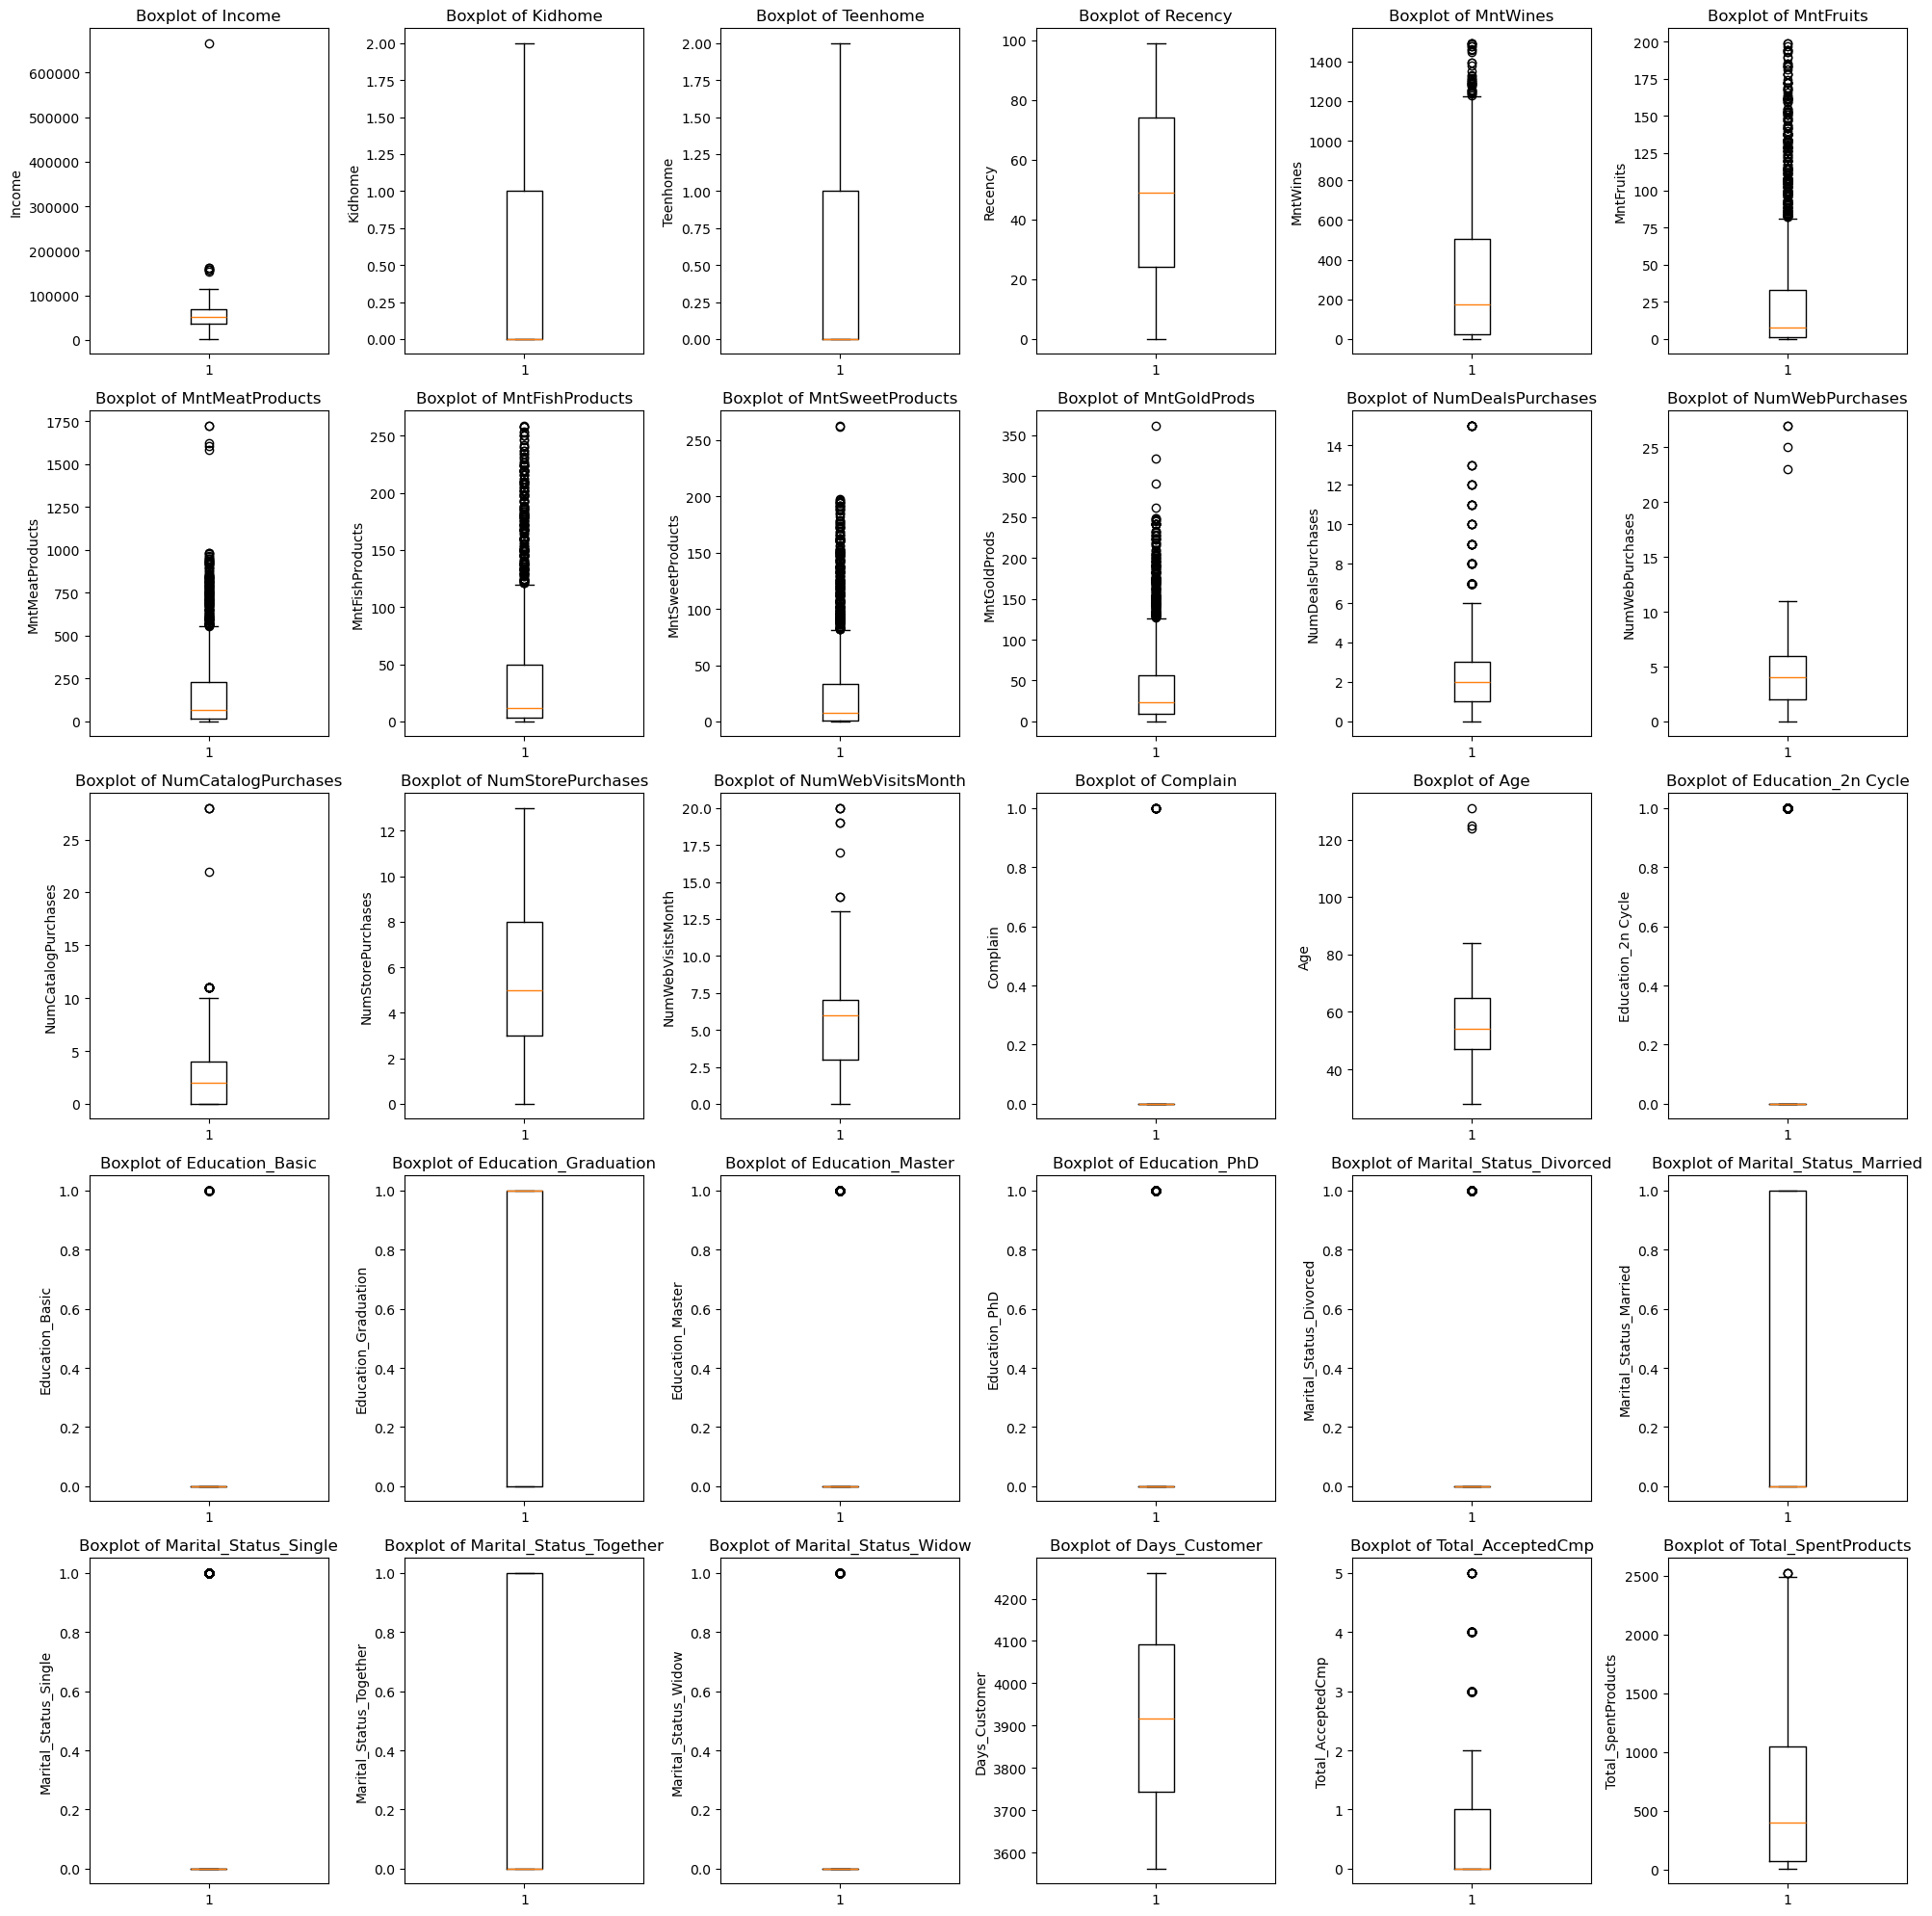

In [13]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(20, 20))
 
for i, column in enumerate(clients.columns):
    axs.flatten()[i].boxplot(clients[column])
    axs.flatten()[i].set_title(f'Boxplot of {column}')
    axs.flatten()[i].set_ylabel(column)
 
plt.tight_layout()
plt.show()


In [14]:
quantiles = np.quantile(clients['Income'], [0,0.25,0.5,0.75,1])
print(f'Quantiles: {quantiles}')

iqr = quantiles[3] - quantiles[1]
minimum_value = quantiles[1] - 1.5 * iqr
maximum_value = quantiles[3] + 1.5 * iqr

outlier_range = (minimum_value, maximum_value)
print(f'Range: {outlier_range}')

Quantiles: [  1730.    35538.75  51741.5   68289.75 666666.  ]
Range: (-13587.75, 117416.25)


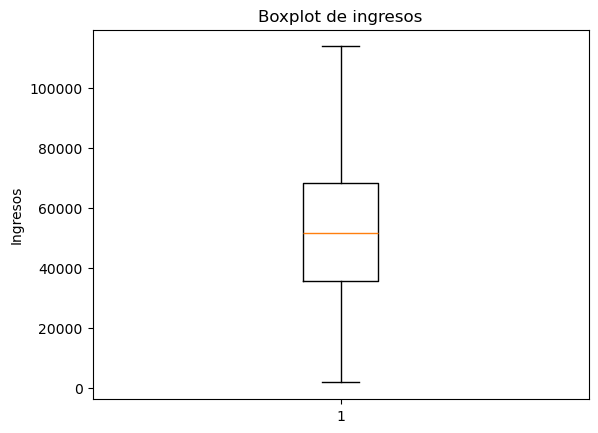

In [15]:
clients = clients[clients.Income < outlier_range[1]]

plt.title('Boxplot de ingresos')
plt.boxplot(clients['Income'])
plt.ylabel('Ingresos')
plt.show()

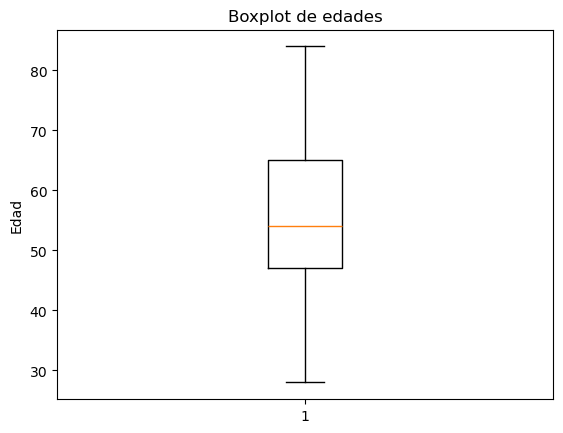

In [16]:
clients = clients[clients.Age < 100]

plt.title('Boxplot de edades')
plt.boxplot(clients['Age'])
plt.ylabel('Edad')
plt.show()

In [17]:
def kMeans(D, k, eps=0.01, mu=None, max_iter=20):
  d = D.shape[1]
  if mu is None:
    mu = np.random.rand(k, d) * (np.max(D, axis=0) - np.min(D, axis=0)) + np.min(D, axis=0)

  if type(mu) == list:
    mu = np.array(mu)

  s = False
  g = 0
  
  while not s:
    C = [np.argmin([np.linalg.norm(mu[j] - x) for j in range(k) if not any(np.isnan(mu[j]))]) for x in D]
    n = np.zeros(mu.shape)
    s = True
    for i in range(k):
      J = [D[j] for j in range(len(D)) if C[j] == i]
      if len(J) > 0:
        n[i] = np.mean(J, axis=0)
      else:
        n[i] = np.random.rand(1, d) * (np.max(D, axis=0) - np.min(D, axis=0)) + np.min(D, axis=0)
      if np.linalg.norm(mu[i] - n[i]) > eps:
        s = False
    mu = n
    g += 1
    if g >= max_iter:
      s = True
  return C, mu

def calculate_covariance_matrix(A, mu):
    n = A.shape[0]
    centered_data = A - mu
    covariance = np.dot(centered_data.T, centered_data) / n
    return covariance
 
total_v = 0
 
def PCA(D, red):
    global total_v
    cov_matrix = calculate_covariance_matrix(D, np.sum(D, axis=0) / D.shape[0])
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    descending_indices = np.argsort(eigenvalues)[::-1]
    descending_eigenvalues = eigenvalues[descending_indices]
    descending_eigenvectors = eigenvectors[:, descending_indices]
    total_v = np.real(np.sum(descending_eigenvalues))
   
    if red < 1:
        retained_variance = np.cumsum(descending_eigenvalues) / total_v
        r = np.argmax(retained_variance >= red) + 1
    elif isinstance(red, int):
        r = red
   
    A = np.dot(D, descending_eigenvectors[:, :r])
    v = np.real(np.sum(descending_eigenvalues[:r]))
    return A, v


def plotClusters(D, C, dimX, dimY, dimZ=None, ax=None):
  h = type(D) == pd.DataFrame
  W = D.columns[dimX] if h else dimX
  X = D.columns[dimY] if h else dimY
  b = D.columns[dimZ] if h and not dimZ is None else dimZ
  if type(D) == pd.DataFrame:
    D = D.values
  x = np.unique(C)
  K = not dimZ is None
  
  if ax is None:
    if K:
      I = plt.figure()
      ax = I.add_subplot(111, projection='3d')
    else:
      I, ax = plt.subplots()
      
  for ci in x:
    f = np.where(C == ci)[0]
    if K:
      ax.scatter(D[f, dimX], D[f, dimY], D[f, dimZ])
    else:
      ax.scatter(D[f, dimX], D[f, dimY])
      
  ax.set_xlabel(W)
  ax.set_ylabel(X)
  
  if K:
    ax.set_zlabel(b)
    
def calculate_sse(A, C, mu):   
    errors = np.zeros(len(A))
    for i in range(len(A)):
        centroid = mu[C[i]]
        errors[i] = np.sum((A[i] - centroid) ** 2)
        sse = np.sum(errors)
    return sse

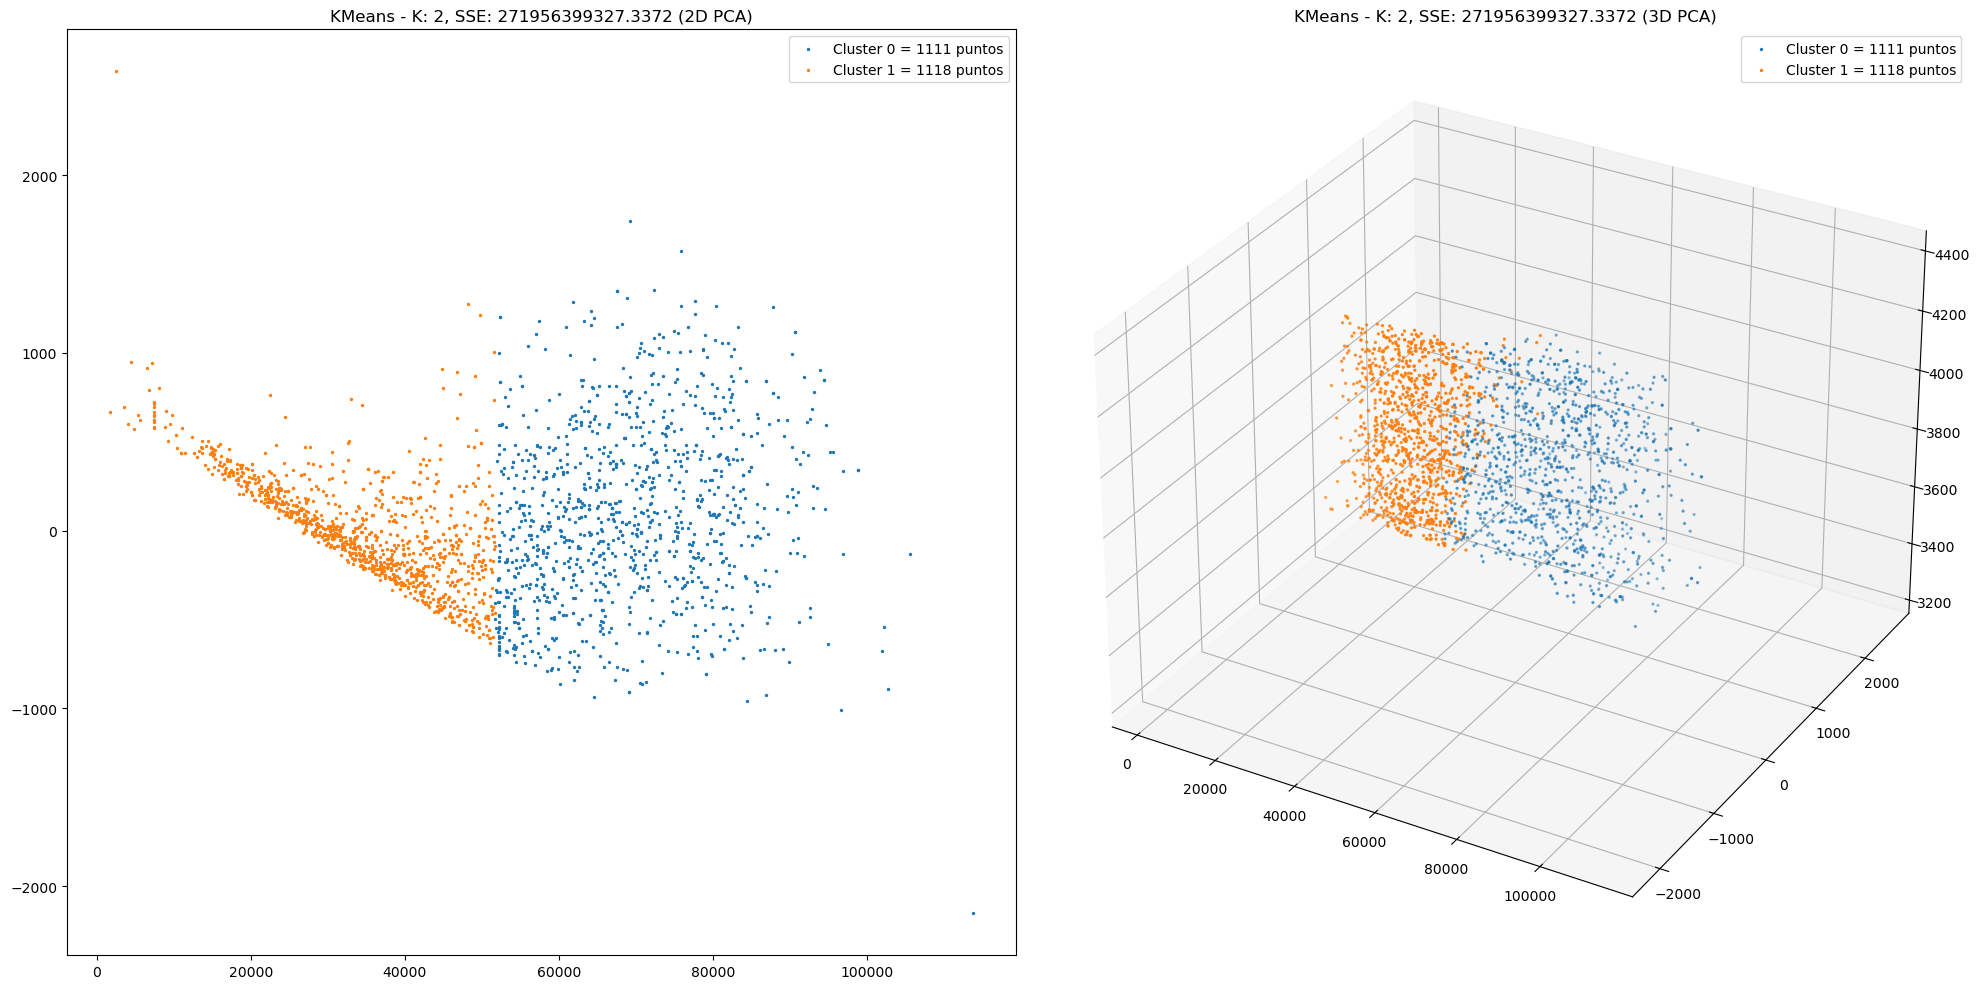

The best clustering for 2 clusters has an SSE value of 271956399327.3372


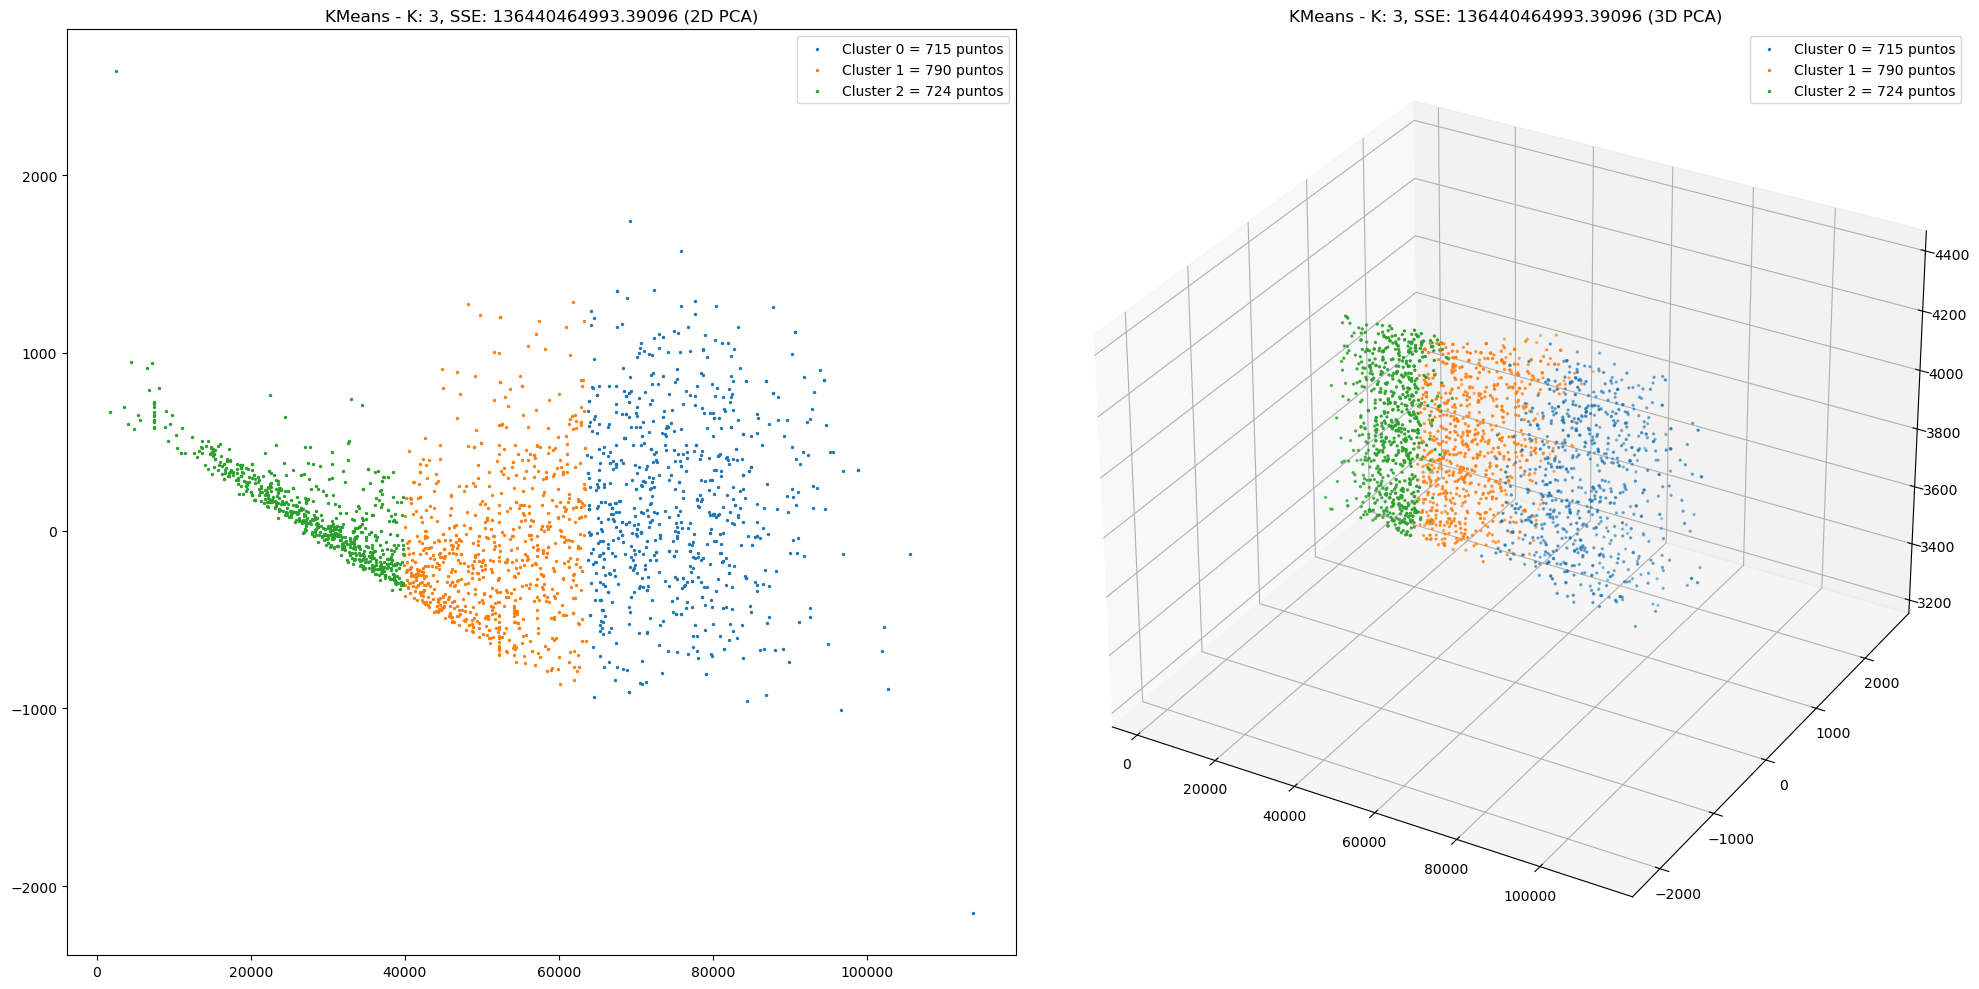

The best clustering for 3 clusters has an SSE value of 136440464993.39096


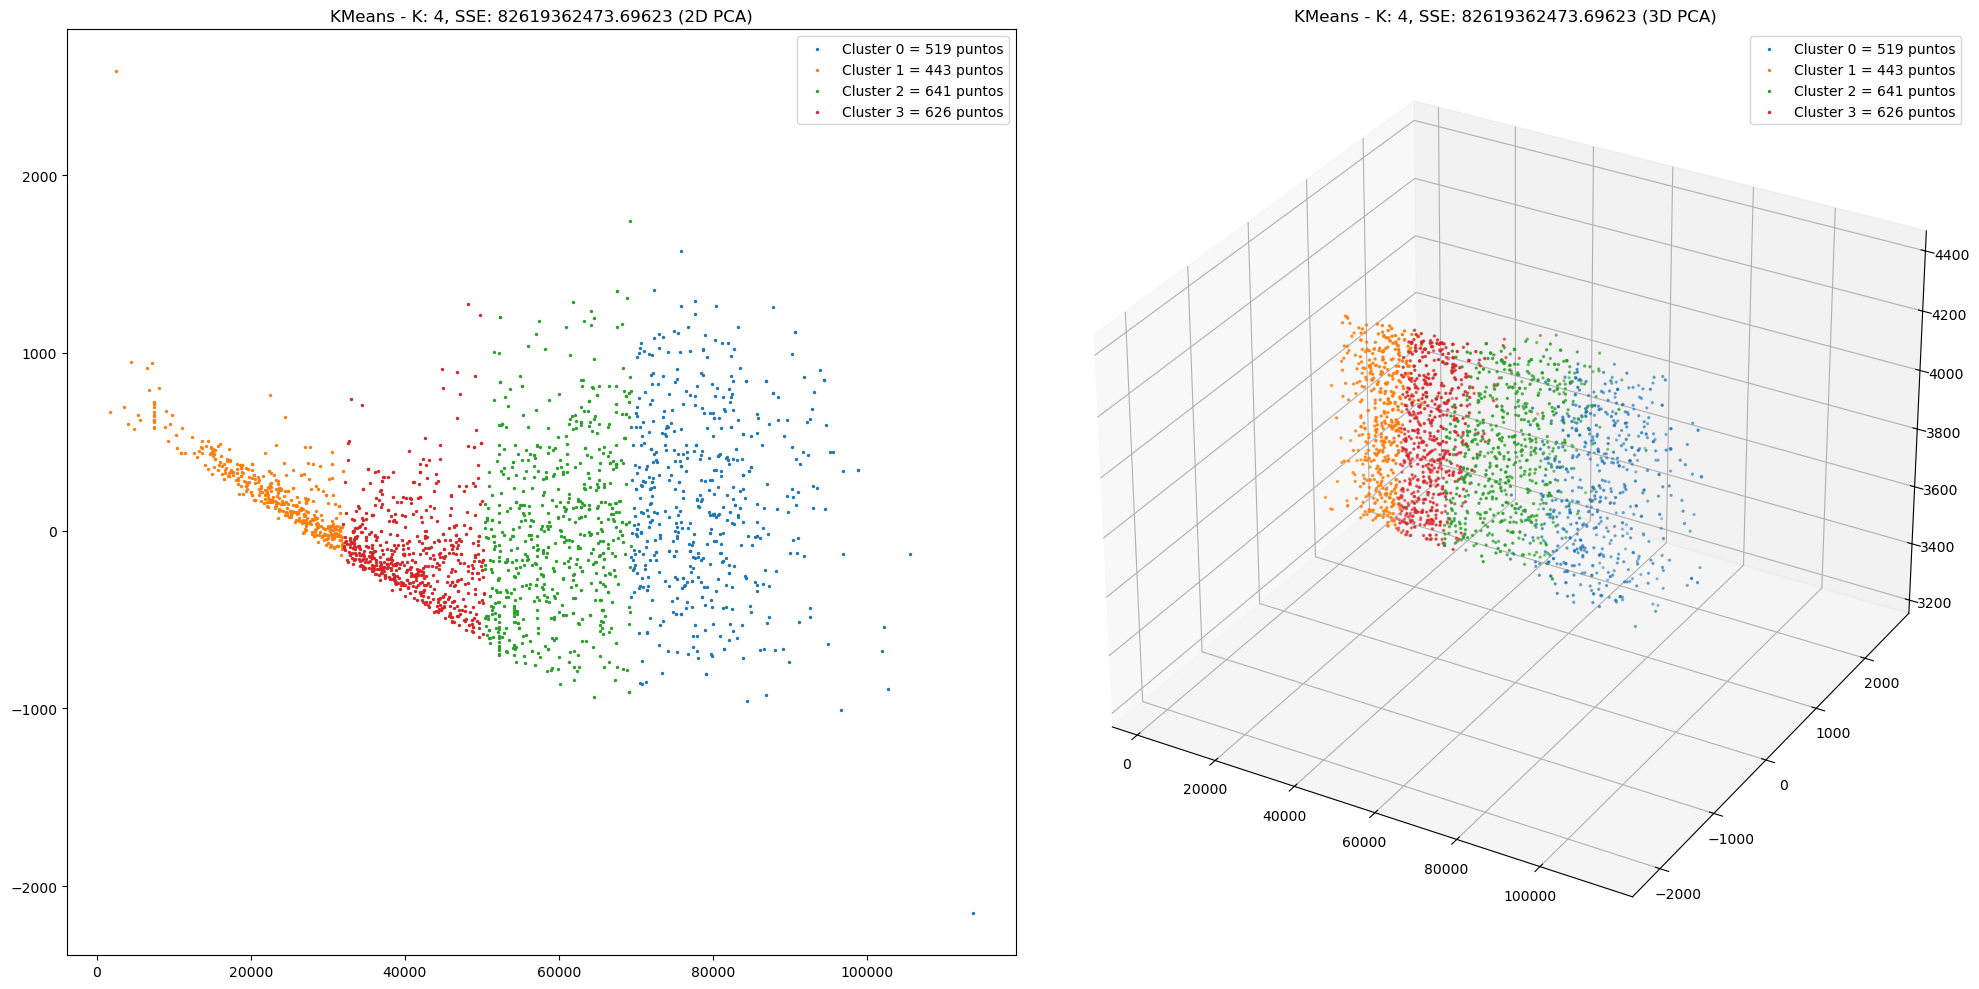

The best clustering for 4 clusters has an SSE value of 82619362473.69623


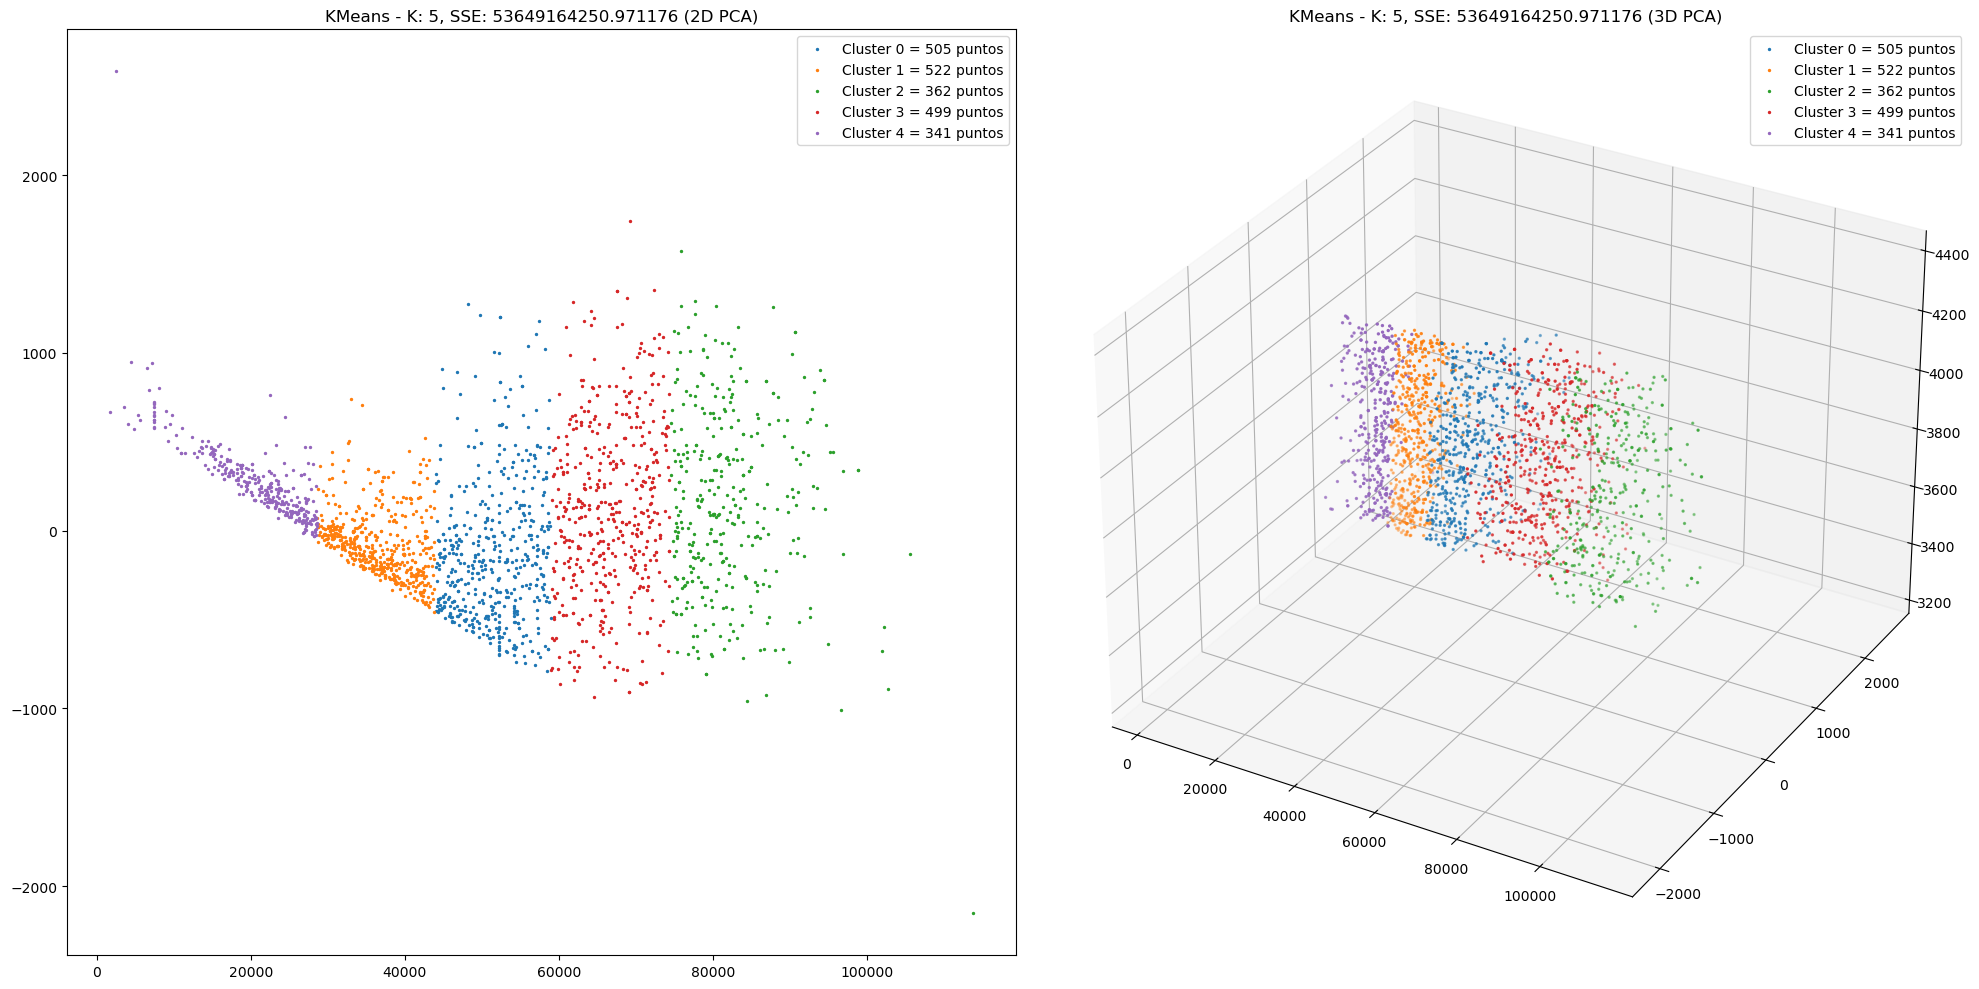

The best clustering for 5 clusters has an SSE value of 53649164250.971176


In [18]:
clients_2D, _ = PCA(clients.values, 2) 
clients_3D, _ = PCA(clients.values, 3)

kmeans_config = [2, 3, 4, 5]
num_iterations = 20

best_clusters_kmeans = [(np.inf, None) for _ in kmeans_config]

for i, k in enumerate(kmeans_config):
    best_sse = np.inf
    best_clusters = None

    for _ in range(num_iterations):
        clusters, centroids = kMeans(clients_2D, k)
        sse = calculate_sse(clients_2D, clusters, centroids)
        if sse < best_sse:
            best_sse = sse
            best_clusters = clusters

    best_clusters_kmeans[i] = (best_sse, best_clusters)  
    
    plt.figure(figsize=(20, 10))
    unique_clusters, counts = np.unique(best_clusters, return_counts=True)

    plt.subplot(1, 2, 1)
    for cluster_label in unique_clusters:
        cluster_mask = (best_clusters == cluster_label)
        plt.scatter(clients_2D[cluster_mask, 0], clients_2D[cluster_mask, 1], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=2)
    plt.title(f'KMeans - K: {k}, SSE: {best_sse} (2D PCA)')
    plt.legend()

    ax = plt.subplot(1, 2, 2, projection='3d')
    for cluster_label in unique_clusters:
        cluster_mask = (best_clusters == cluster_label)
        ax.scatter(clients_3D[cluster_mask, 0], clients_3D[cluster_mask, 1], clients_3D[cluster_mask, 2], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=2)
    plt.title(f'KMeans - K: {k}, SSE: {best_sse} (3D PCA)')
    ax.legend()

    plt.tight_layout()
    plt.show()

    print(f"The best clustering for {k} clusters has an SSE value of {best_sse}")